## **These codes are convereted from R**

In [5]:
# Required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("compas-scores-two-years.csv")

# Select relevant columns (like dplyr::select)
df = df[['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex',
         'priors_count', 'days_b_screening_arrest', 'decile_score',
         'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out']]

# Apply filtering like in R:
df = df[
    (df['days_b_screening_arrest'].between(-30, 30)) &
    (df['is_recid'] != -1) &
    (df['c_charge_degree'] != "O") &
    (df['score_text'] != "N/A")
].copy()

# Convert jail dates and compute length of stay
df['c_jail_in'] = pd.to_datetime(df['c_jail_in'], errors='coerce')
df['c_jail_out'] = pd.to_datetime(df['c_jail_out'], errors='coerce')
df['length_of_stay'] = (df['c_jail_out'] - df['c_jail_in']).dt.days

# Correlation between length of stay and decile score
correlation = df[['length_of_stay', 'decile_score']].corr().iloc[0, 1]
print("Correlation between length of stay and decile score:", round(correlation, 4))


Correlation between length of stay and decile score: 0.2075


In [6]:
print("Age Category Distribution:")
print(df['age_cat'].value_counts())

print("\nRace Distribution:")
print(df['race'].value_counts(normalize=True) * 100)

print("\nScore Text (Risk Category):")
print(df['score_text'].value_counts())

print("\nSex Distribution:")
print(df['sex'].value_counts(normalize=True) * 100)

print("\nTwo-Year Recidivism Count:")
print(df['two_year_recid'].value_counts())


Age Category Distribution:
age_cat
25 - 45            3532
Less than 25       1347
Greater than 45    1293
Name: count, dtype: int64

Race Distribution:
race
African-American    51.441996
Caucasian           34.073234
Hispanic             8.246922
Other                5.557356
Asian                0.502268
Native American      0.178224
Name: proportion, dtype: float64

Score Text (Risk Category):
score_text
Low       3421
Medium    1607
High      1144
Name: count, dtype: int64

Sex Distribution:
sex
Male      80.962411
Female    19.037589
Name: proportion, dtype: float64

Two-Year Recidivism Count:
two_year_recid
0    3363
1    2809
Name: count, dtype: int64


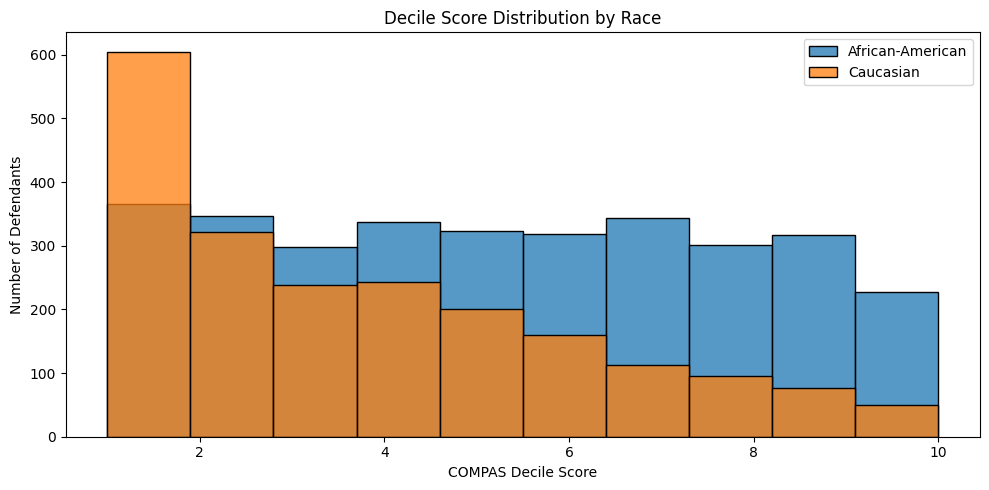

In [7]:
# Plot decile score distribution by race
plt.figure(figsize=(10, 5))
for race in ['African-American', 'Caucasian']:
    sns.histplot(
        data=df[df['race'] == race],
        x='decile_score',
        bins=10,
        label=race,
        stat='count',
        kde=False
    )

plt.title('Decile Score Distribution by Race')
plt.xlabel('COMPAS Decile Score')
plt.ylabel('Number of Defendants')
plt.legend()
plt.tight_layout()
plt.show()


# A first analysis of the COMPAS dataset

## Dataset description

We will examine the ProPublica COMPAS dataset, which contains the records of all criminal defendants who were subject to COMPAS screening in Broward County, Florida, during 2013 and 2014. For each defendant, various information fields (‘features’) were gathered by ProPublica. Broadly, these fields are related to the defendant’s demographic information (e.g., gender and race), criminal history (e.g., the number of prior offenses) and administrative information about the case (e.g., the case number, arrest date). Finally, the dataset contains the risk of recidivism predicted by the COMPAS tool, and also information about whether the defendant did actually recidivate or not (ground truth label for us).

The COMPAS score uses answers to 137 questions to assign a risk score to defendants -- essentially an estimate of the likelihood of re-arrest. The actual output is two-fold: a risk rating of 1-10 and a "low", "medium", or "high" risk label.

Link to dataset: https://github.com/propublica/compas-analysis

The file we will analyze is: compas-scores-two-years.csv

Link to the ProPublica article:

https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing

Some of the code below is adapted from the Propublica github repository above, and from

https://investigate.ai/propublica-criminal-sentencing/week-5-1-machine-bias-class/

## Download the data

We first need to load the data from the ProPublica repo:
https://github.com/propublica/compas-analysis

In [2]:
%matplotlib inline

import urllib.request
import os,sys
import numpy as np
import pandas as pd

from sklearn import feature_extraction
from sklearn import preprocessing
from random import seed, shuffle

SEED = 1234
seed(SEED)
np.random.seed(SEED)

def check_data_file(fname):
    files = os.listdir(".") # get the current directory listing
    print("Looking for file '%s' in the current directory...",fname)

    if fname not in files:
        print("'%s' not found! Downloading from GitHub...",fname)
        addr = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
        response = urllib.request.urlopen(addr)
        data = response.read()
        fileOut = open(fname, "wb")
        fileOut.write(data)
        fileOut.close()
        print("'%s' download and saved locally..",fname)
    else:
        print("File found in current directory..")

COMPAS_INPUT_FILE = "compas-scores-two-years.csv"
check_data_file(COMPAS_INPUT_FILE)

Looking for file '%s' in the current directory... compas-scores-two-years.csv
'%s' not found! Downloading from GitHub... compas-scores-two-years.csv
'%s' download and saved locally.. compas-scores-two-years.csv


## Loading and cleaning data

The following code load the data using pandas and cleans it according to ProPublica's cleaning:

"
If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.

We coded the recidivist flag -- is_recid -- to be -1 if we could not find a compas case at all.

In a similar vein, ordinary traffic offenses -- those with a c_charge_degree of 'O' -- will not result in Jail time are removed

We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility."
"

Finally, it converts the data to a dictionary with np arrays, which will be useful later

In [3]:
# load the file
df = pd.read_csv(COMPAS_INPUT_FILE)
# print(df.shape)

df = df.dropna(subset=["days_b_screening_arrest"]) # dropping missing vals

df = df[
    (df.days_b_screening_arrest <= 30) &
    (df.days_b_screening_arrest >= -30) &
    (df.is_recid != -1) &
    (df.c_charge_degree != 'O') &
    (df.score_text != 'N/A')
]

df.reset_index(inplace=True, drop=True) # renumber the rows from 0 again
# df.shape

# Conversion to dictionary with np arrays
data = df.to_dict('list')
for k in data.keys():
    data[k] = np.array(data[k])

In [4]:
# Number of defendants per race
df['race'].value_counts()


,count
race,
African-American,3175
Caucasian,2103
Hispanic,509
Other,343
Asian,31
Native American,11


## Exploring the dataset

The following pandas commands are very convenient to explore the data. Uncomment them to explore the data.

<span style="color:red">TODO</span>: Add a command to print the number of defendents per race.

In the following, we will look mostly at African-Americans and Caucasians(termed blacks and whites for short)

In [8]:
# df.head() # check some examples of data
# df.columns # prints the features
# df.isnull().sum() # check for missing values
# df.describe() # generates descriptive statistics (e.g., to check for outliers)
# df.race.unique() # different races we have in the dataset
# df.age_cat.value_counts() # number of people by age category
# df.score_text.value_counts() # number of people by COMPAS risk category

# TODO: Insert your code below this

# Number of defendants per race
print("Number of defendants by race:")
print(df['race'].value_counts())







Number of defendants by race:
race
African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: count, dtype: int64


## Basic analysis of the bias in COMPAS scores

We now look at the COMPAS scores (deciles first, then text scores) as a function of the sensitive attribute (race or gender) to observe potential differences.

We start by observing the scores for different groupes.

<span style="color:red">TODO</span>: Plot the histograms of decile scores for Black and White defendant and observe the difference.

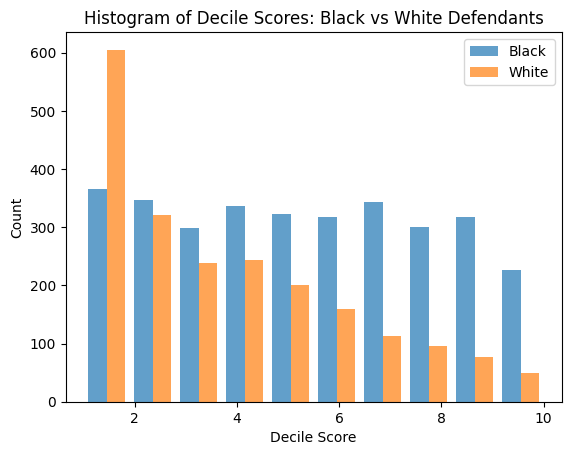

In [9]:
# Histogram of decile scores for Blacks (blue) and Whites (orange)
# TODO: Insert your code below this
import matplotlib.pyplot as plt

black_scores = df[df['race'] == 'African-American']['decile_score']
white_scores = df[df['race'] == 'Caucasian']['decile_score']

plt.hist([black_scores, white_scores], bins=10, label=['Black', 'White'], alpha=0.7)
plt.xlabel('Decile Score')
plt.ylabel('Count')
plt.title('Histogram of Decile Scores: Black vs White Defendants')
plt.legend()
plt.show()


The above observation can be explained by a dependence between the race and true label.

In [10]:
# recidivism rates by race
recid_race = pd.crosstab(df.race, df.two_year_recid)
recid_race['rate'] = recid_race[1] / recid_race.sum(axis=1)
recid_race

two_year_recid,0,1,rate
race,,,
African-American,1514,1661,0.523150
Asian,23,8,0.258065
Caucasian,1281,822,0.390870
Hispanic,320,189,0.371316
Native American,6,5,0.454545
Other,219,124,0.361516


We now look at whether we observe a similar phenomenon on the text scores of COMPAS (low, medium, high risk).

In [11]:
# high risk rates by race
score_race = pd.crosstab(df.race, df.score_text)
score_race['High risk rate'] = score_race['High'] / score_race.sum(axis=1)
score_race

score_text,High,Low,Medium,High risk rate
race,,,,
African-American,845,1346,984,0.266142
Asian,3,24,4,0.096774
Caucasian,223,1407,473,0.106039
Hispanic,47,368,94,0.092338
Native American,4,3,4,0.363636
Other,22,273,48,0.064140


### Fairness metrics for the COMPAS scores

We do not have the actual scores that are used to compte text scores Low-Med-High; hence we cannot investigate directly the calibration. However, we can use the decile score as a proxy, and we can investigate PPV.

Let us first plot the probability of recidivism by decile score. We observe that it is not very far from a diagonale.

<Axes: xlabel='decile_score'>

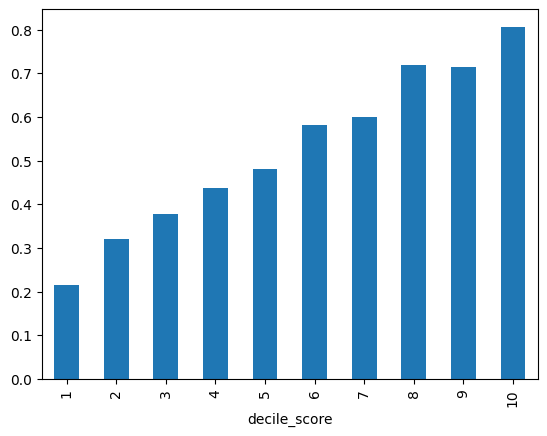

In [12]:
# probability of recidivism by decile
df['two_year_recid'].groupby(df.decile_score).mean().plot(kind='bar')

<span style="color:red">TODO</span>: Plot a similar graph with separated bars for Blacks and Whites.

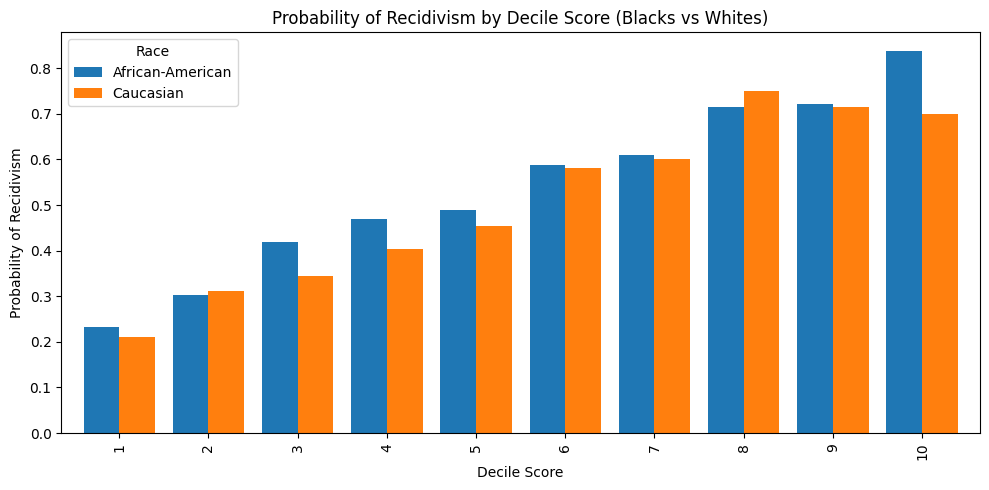

In [13]:
# probability of recidivism by decile and race
# TODO: Insert your code below this


# Keep only Black and White defendants
subset = df[df['race'].isin(['African-American', 'Caucasian'])].copy()
subset['two_year_recid'] = pd.to_numeric(subset['two_year_recid'], errors='coerce')

# Group by decile and race, calculate average recidivism
grouped = subset.groupby(['decile_score', 'race'])['two_year_recid'].mean().unstack()

# Plot with separated bars
grouped.plot(kind='bar', figsize=(10, 5), width=0.8)
plt.xlabel('Decile Score')
plt.ylabel('Probability of Recidivism')
plt.title('Probability of Recidivism by Decile Score (Blacks vs Whites)')
plt.legend(title='Race')
plt.tight_layout()
plt.show()



To further analyze the COMPAS score as a classifier, we transform it into a binary outcome by splitting "low" (class 0) from "medium or high" risk (class 1). We can then compute standard quantities such as the confusion matrix or PPV.

In [14]:
# COMPAS recidivism confusion matrix
df['guessed_recid'] = df.score_text != 'Low'
df['actual_recid'] = df.two_year_recid == 1
cm = pd.crosstab(df.actual_recid, df.guessed_recid)
cm # for "confusion matrix"

guessed_recid,False,True
actual_recid,,
False,2345,1018
True,1076,1733


We finally compute the PPV, TPR and FPR of the COMPAS classifier.

<span style="color:red">TODO</span>: Complete the print_ppv_fpv function. Observe the differences in the metrics between Blacks and Whites and comment.

In [15]:
# cm is a confusion matrix. The rows are guessed, the columns are actual
def print_ppv_fpv(cm):
    # the indices here are [col][row] or [actual][guessed]
    TN = cm[False][False]
    TP = cm[True][True]
    FN = cm[True][False]
    FP = cm[False][True]

    print('Accuracy: ', round((TP + TN) / (TP + TN + FP + FN), 3))
    print('PPV: ', round(TP / (TP + FP), 3) if (TP + FP) > 0 else 'NA')
    print('FPR: ', round(FP / (FP + TN), 3) if (FP + TN) > 0 else 'NA')
    print('FNR: ', round(FN / (FN + TP), 3) if (FN + TP) > 0 else 'NA')
    print()



def print_metrics(guessed, actual):
    cm = pd.crosstab(guessed, actual, rownames=['guessed'], colnames=['actual'])
    print(cm)
    print()
    print_ppv_fpv(cm)

print('White')
subset = df[df.race == 'Caucasian']
print_metrics(subset.guessed_recid, subset.actual_recid)

print('Black')
subset = df[df.race == 'African-American']
print_metrics(subset.guessed_recid, subset.actual_recid)

White
actual   False  True 
guessed              
False      999    408
True       282    414

Accuracy:  0.672
PPV:  0.595
FPR:  0.22
FNR:  0.496

Black
actual   False  True 
guessed              
False      873    473
True       641   1188

Accuracy:  0.649
PPV:  0.65
FPR:  0.423
FNR:  0.285



Conclusion: the False Positive Rate is substantially higher for black defendants, but the PPV is similar between blacks and whites. That is, the COMPAS score satisfies sufficiency, but not separation.

## Training a classifier from the ground truth label

We now train a classifier (a simple logistic regression) on the label two_year_recid. We work on a subset of features: ["age_cat", "race", "sex", "priors_count", "c_charge_degree"].

<span style="color:red">TODO</span>: Complete the model definition and fitting.

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from collections import defaultdict

FEATURES_CLASSIFICATION = ["age_cat", "race", "sex", "priors_count", "c_charge_degree"] #features to be used for classification
CONT_VARIABLES = ["priors_count"] # continuous features, will need to be handled separately from categorical features, categorical features will be encoded using one-hot
CLASS_FEATURE = "two_year_recid" # the decision variable
SENSITIVE_ATTRS = ["race"]


y = data[CLASS_FEATURE]
X = np.array([]).reshape(len(y), 0) # empty array with num rows same as num examples, will hstack the features to it
x_control = defaultdict(list)

for attr in FEATURES_CLASSIFICATION:
    vals = data[attr]
    if attr in CONT_VARIABLES:
        vals = [float(v) for v in vals]
        vals = preprocessing.scale(vals) # 0 mean and 1 variance
        vals = np.reshape(vals, (len(y), -1)) # convert from 1-d arr to a 2-d arr with one col

    else: # this encodes categorical variables in a numerical way -- there are other ways to do it
        enc = preprocessing.LabelBinarizer()
        enc.fit(vals)
        vals = enc.transform(vals)

    # add to learnable features
    X = np.hstack((X, vals))


# the following is a very dirty way to keep track of the race after the train_test_split
ind = data["race"]=="African-American"
X_b = X[ind]
y_b = y[ind]
ind = data["race"]=="Caucasian"
X_w = X[ind]
y_w = y[ind]
ind = [data["race"][i]!="Caucasian" and data["race"][i]!="African-American" for i in range(len(y))]
X_n = X[ind]
y_n = y[ind]

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size=0.3, random_state=1234)
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_w, y_w, test_size=0.3, random_state=5678)
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_n, y_n, test_size=0.3, random_state=9012)

X_train = np.vstack((X_train_b, X_train_w, X_train_n))
y_train = np.hstack((y_train_b, y_train_w, y_train_n))
X_test = np.vstack((X_test_b, X_test_w, X_test_n))
y_test = np.hstack((y_test_b, y_test_w, y_test_n))


# TODO: Uncomment and complete the code below

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)



We can then compute the model accuracy. Compare to the COMPAS accuracy.

In [17]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.6540744738262277


We can also plot the ROC curve for the model on the global population.

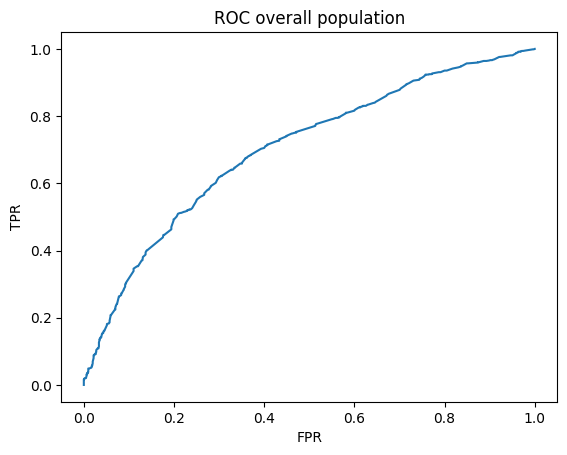

In [18]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

scores = model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, scores[:,1])

plt.plot(fpr, tpr)

plt.title('ROC overall population')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()


<span style="color:red">TODO</span>: Plot the ROC curve for Blacks and Whites in two separate curves (in the same plot). What do you observe?

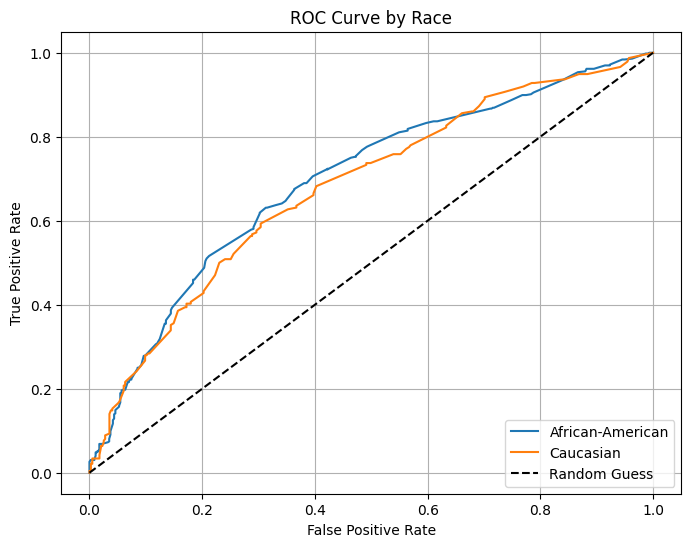

In [21]:
# TODO: Insert your code below this line
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt



# Predict probabilities
scores_b = model.predict_proba(X_test_b)
scores_w = model.predict_proba(X_test_w)

# Compute ROC curves
fpr_b, tpr_b, _ = roc_curve(y_test_b, scores_b[:, 1])
fpr_w, tpr_w, _ = roc_curve(y_test_w, scores_w[:, 1])

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_b, tpr_b, label="African-American")
plt.plot(fpr_w, tpr_w, label="Caucasian")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.title('ROC Curve by Race')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()




We can finally check the fairness of this simple logistic regression, when choosing an arbitrary threshold common to the two groups.

<span style="color:red">TODO</span>: Compute the predictions for a common threshold (threshold_common), then compute the PPV, TPR, FPR (you can use the print_metrics function from above). Comment.

In [26]:
threshold_common = 0.5
# TODO: Insert your code below this line
from sklearn.metrics import confusion_matrix

def print_metrics(y_true, y_scores, threshold=0.5, group_name=""):
    y_pred = (y_scores >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0.0  # precision
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0  # recall
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0  # false positive rate

    print(f"--- Metrics for {group_name} ---")
    print(f"PPV (Precision): {ppv:.3f}")
    print(f"TPR (Recall):    {tpr:.3f}")
    print(f"FPR:             {fpr:.3f}")
    print()

# Get predicted probabilities
scores_b = model.predict_proba(X_test_b)[:, 1]
scores_w = model.predict_proba(X_test_w)[:, 1]

# Compute metrics for both groups
print_metrics(y_test_b, scores_b, threshold_common, group_name="African-American")
print_metrics(y_test_w, scores_w, threshold_common, group_name="Caucasian")



--- Metrics for African-American ---
PPV (Precision): 0.669
TPR (Recall):    0.647
FPR:             0.348

--- Metrics for Caucasian ---
PPV (Precision): 0.572
TPR (Recall):    0.403
FPR:             0.180



Finally, we can also investigate the calibration more finely using the calibration module from sklearn.

<span style="color:red">TODO</span>: Complete the code below to plot the calibration curve for the whole population.

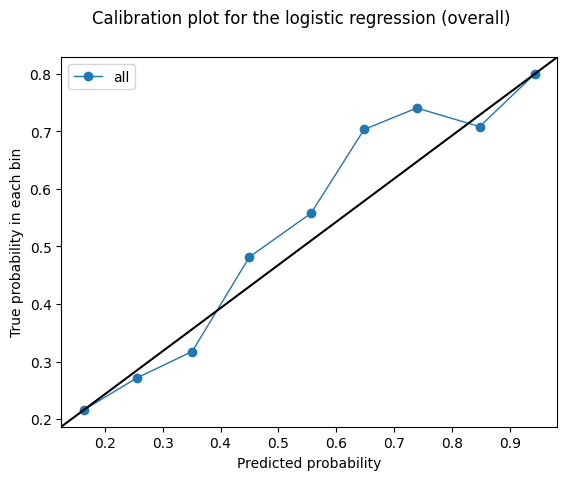

In [27]:
from sklearn.calibration import calibration_curve
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

# TODO: Uncomment and complete the code below
# scores = ...
# prob_true, prob_pred = ...
scores = model.predict_proba(X_test)[:, 1]
prob_true, prob_pred = calibration_curve(y_test, scores, n_bins=10)


fig, ax = plt.subplots()
# only this line is calibration curves
plt.plot(prob_pred,prob_true, marker='o', linewidth=1, label='all')

# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot for the logistic regression (overall)')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show()

<span style="color:red">TODO</span>: Complete the code below to plot the calibration curve for the blacks and white separately. Conclude.

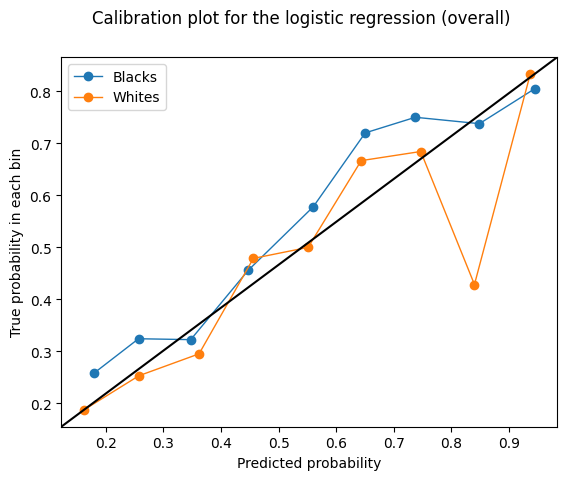

In [28]:
# TODO: Uncomment and complete the code below
# ...
# prob_true_b, prob_pred_b = ...
# ...
# prob_true_w, prob_pred_w = ...


scores_b = model.predict_proba(X_test_b)[:, 1]
prob_true_b, prob_pred_b = calibration_curve(y_test_b, scores_b, n_bins=10)

scores_w = model.predict_proba(X_test_w)[:, 1]
prob_true_w, prob_pred_w = calibration_curve(y_test_w, scores_w, n_bins=10)



fig, ax = plt.subplots()
# only this line is calibration curves
plt.plot(prob_pred_b,prob_true_b, marker='o', linewidth=1, label='Blacks')
plt.plot(prob_pred_w,prob_true_w, marker='o', linewidth=1, label='Whites')

# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot for the logistic regression (overall)')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show()